In [69]:
# Import standard data handling and ML libraries
import pandas as pd
import numpy as np

# Preprocessing and scaling
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP for explainability
import shap


## Data Collection and Loading

In [70]:
df = pd.read_csv('/content/loan_approval_dataset.csv')

# Print the first 5 rows of the dataset
df.head()

,Applicant_ID,Age,Income,Credit_Score,Loan_Amount,Loan_Term,Interest_Rate,Employment_Status,Debt_to_Income_Ratio,Marital_Status,Number_of_Dependents,Property_Ownership,Loan_Purpose,Previous_Defaults
0,1,56,21920,639,452748,72,4.53,Unemployed,43.35,Married,2,Mortgage,Business,0
1,2,69,126121,655,257134,60,5.38,Unemployed,10.42,Divorced,0,Mortgage,Education,0
2,3,46,96872,467,226437,72,3.46,Self-Employed,45.39,Divorced,4,Mortgage,Car,0
3,4,32,101132,751,310480,12,14.00,Unemployed,8.58,Single,2,Mortgage,Business,0
4,5,60,22093,404,13070,12,9.13,Self-Employed,20.70,Divorced,1,Mortgage,Home,0


In [71]:
# Display data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Applicant_ID          5000 non-null   int64  
 1   Age                   5000 non-null   int64  
 2   Income                5000 non-null   int64  
 3   Credit_Score          5000 non-null   int64  
 4   Loan_Amount           5000 non-null   int64  
 5   Loan_Term             5000 non-null   int64  
 6   Interest_Rate         5000 non-null   float64
 7   Employment_Status     5000 non-null   object 
 8   Debt_to_Income_Ratio  5000 non-null   float64
 9   Marital_Status        5000 non-null   object 
 10  Number_of_Dependents  5000 non-null   int64  
 11  Property_Ownership    5000 non-null   object 
 12  Loan_Purpose          5000 non-null   object 
 13  Previous_Defaults     5000 non-null   int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 547.0+ KB


In [72]:
# Dataset Statistics
df.describe()

,Applicant_ID,Age,Income,Credit_Score,Loan_Amount,Loan_Term,Interest_Rate,Debt_to_Income_Ratio,Number_of_Dependents,Previous_Defaults
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,43.584600,110220.247000,574.183200,252118.47900,41.769600,8.873018,27.177244,2.010200,0.099400
std,1443.520003,14.919094,52075.384023,160.437715,142580.00452,20.598868,3.622642,12.888572,1.398459,0.299228
min,1.000000,18.000000,20028.000000,300.000000,5050.00000,12.000000,2.500000,5.000000,0.000000,0.000000
25%,1250.750000,31.000000,64751.000000,434.750000,129940.25000,24.000000,5.790000,16.030000,1.000000,0.000000
50%,2500.500000,43.000000,110180.500000,573.000000,250846.50000,36.000000,8.900000,27.220000,2.000000,0.000000
75%,3750.250000,56.000000,155749.750000,715.000000,378021.75000,60.000000,11.970000,38.235000,3.000000,0.000000
max,5000.000000,69.000000,199992.000000,849.000000,499651.00000,72.000000,15.000000,49.990000,4.000000,1.000000


## Clean the dataset:
### Handle missing values.
### Encode categorical variables.
### Normalize numerical features.

In [73]:
def suggest_categorical_columns(df, unique_thresh=20, unique_ratio_thresh=0.05):
    suggested = []

    # Columns with object or category dtype
    cat_by_dtype = df.select_dtypes(include=['object', 'category']).columns.tolist()
    suggested.extend(cat_by_dtype)

    # Numeric columns with few unique values (likely categorical)
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        unique_vals = df[col].nunique()
        unique_ratio = unique_vals / len(df)
        if unique_vals <= unique_thresh or unique_ratio <= unique_ratio_thresh:
            suggested.append(col)

    # Remove duplicates
    suggested = list(set(suggested))
    return suggested



In [74]:
cat_cols = suggest_categorical_columns(df)
print("Suggested categorical columns:", cat_cols)


Suggested categorical columns: ['Property_Ownership', 'Marital_Status', 'Employment_Status', 'Previous_Defaults', 'Loan_Purpose', 'Age', 'Loan_Term', 'Number_of_Dependents']


In [75]:
# Identify numerical columns to normalize BEFORE encoding changes dtypes
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(cat_cols)
print("Numerical columns to normalize:", num_cols.tolist())

Numerical columns to normalize: ['Applicant_ID', 'Credit_Score', 'Debt_to_Income_Ratio', 'Income', 'Interest_Rate', 'Loan_Amount']


In [76]:
# Label Encoding (good for tree models)
label_encoder = LabelEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    print(f"Label encoded column: {col}")

Label encoded column: Property_Ownership
Label encoded column: Marital_Status
Label encoded column: Employment_Status
Label encoded column: Previous_Defaults
Label encoded column: Loan_Purpose
Label encoded column: Age
Label encoded column: Loan_Term
Label encoded column: Number_of_Dependents


In [78]:
# Replace inf and -inf with NaN in numerical columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

# Fill missing values with the column mean
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

In [79]:
# Normalize numerical columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

## Feature Engineering
### Create new features based on existing data to enhance prediction accuracy.
### Scale numerical features to ensure consistency.

In [80]:
# Create new features based on existing data to enhance prediction accuracy.
# Loan-to-Income Ratio
df['Loan_to_Income_Ratio'] = df['Loan_Amount'] / df['Income']

# EMI: Estimated Monthly Installment
df['EMI'] = df['Loan_Amount'] / df['Loan_Term']


In [81]:
df[['Loan_to_Income_Ratio', 'EMI']] = df[['Loan_to_Income_Ratio', 'EMI']].replace([np.inf, -np.inf], np.nan)
df[['Loan_to_Income_Ratio', 'EMI']] = df[['Loan_to_Income_Ratio', 'EMI']].fillna(df[['Loan_to_Income_Ratio', 'EMI']].mean())


In [82]:
print(df[['Loan_to_Income_Ratio', 'EMI']].isna().sum())

Loan_to_Income_Ratio    0
EMI                     0
dtype: int64


## Model Building and Evaluation
### Split the data into training and testing sets.
### Train a Random Forest classifier or another algorithm of your choice.
### Evaluate the model using:

*   Accuracy
*   Confusion Matrix
*   Classification Report (Precision, Recall, F1-Score)

### Analyze feature importance to determine which factors impact loan defaults.

In [83]:
# Split the data into training and testing sets.
from sklearn.model_selection import train_test_split

X = df.drop(['Applicant_ID', 'Previous_Defaults'], axis=1)
y = df['Previous_Defaults']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [84]:
#  Train a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [85]:
# Accuracy
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.907


In [86]:
# Confusion Matrix
y_pred = rf_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[907   0]
 [ 93   0]]


In [87]:
# Classification Report (Precision, Recall, F1-Score)
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       907
           1       0.00      0.00      0.00        93

    accuracy                           0.91      1000
   macro avg       0.45      0.50      0.48      1000
weighted avg       0.82      0.91      0.86      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
#  Train a SVC
from sklearn.svm import SVC
svc_classifier = SVC(random_state=42)
svc_classifier.fit(X_train, y_train)


SVC(random_state=42)

In [89]:
# Analyze feature importance to determine which factors impact loan defaults.
feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance_df)


Feature Importance:
                 Feature  Importance
1                 Income    0.109616
7   Debt_to_Income_Ratio    0.107108
12  Loan_to_Income_Ratio    0.105662
5          Interest_Rate    0.101121
2           Credit_Score    0.100946
3            Loan_Amount    0.099059
13                   EMI    0.094910
0                    Age    0.083512
11          Loan_Purpose    0.038483
4              Loan_Term    0.038306
9   Number_of_Dependents    0.035901
8         Marital_Status    0.032542
10    Property_Ownership    0.027212
6      Employment_Status    0.025622


/tmp/ipython-input-90-295042391.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


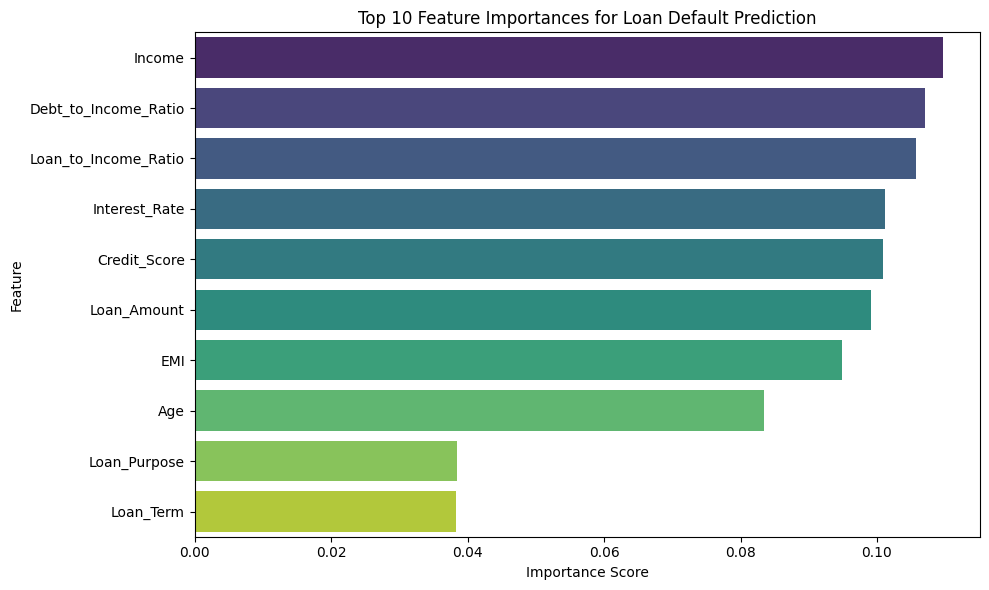

In [90]:
# Display top 10 most important features
top_features = feature_importance_df.head(10)
# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances for Loan Default Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [91]:
# Calculate SHAP values for test set
X_test_aligned = X_test[X_train.columns]

In [92]:
# Clean data: replace inf and fill NaNs
X_test_aligned = X_test_aligned.replace([np.inf, -np.inf], np.nan)
X_test_aligned = X_test_aligned.fillna(X_test_aligned.mean())

In [101]:
demographic_col = 'Employment_Status'

print("Groups in", demographic_col, ":", X_test[demographic_col].unique())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for group in X_test[demographic_col].unique():
    idx = X_test[X_test[demographic_col] == group].index
    y_true_group = y_test.loc[idx]
    y_pred_group = rf_classifier.predict(X_test.loc[idx])

    print(f"Performance for {demographic_col} = {group}:")
    print(f"  Accuracy:  {accuracy_score(y_true_group, y_pred_group):.4f}")
    print(f"  Precision: {precision_score(y_true_group, y_pred_group, zero_division=0):.4f}")
    print(f"  Recall:    {recall_score(y_true_group, y_pred_group, zero_division=0):.4f}")
    print(f"  F1-Score:  {f1_score(y_true_group, y_pred_group, zero_division=0):.4f}")
    print()


Groups in Employment_Status : [1 0 2]
Performance for Employment_Status = 1:
  Accuracy:  0.8997
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Performance for Employment_Status = 0:
  Accuracy:  0.9018
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Performance for Employment_Status = 2:
  Accuracy:  0.9194
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000



Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (1000, 14, 2)
Selected shap_values[:, :, 1] for class 1.
SHAP values shape for class 1 (after potential selection): (1000, 14)
X_test_aligned shape: (1000, 14)


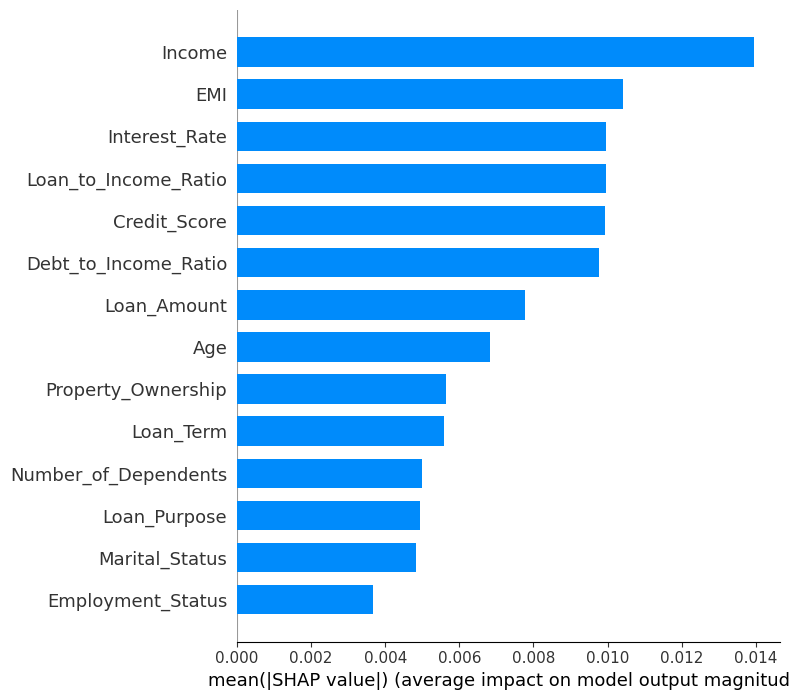

In [102]:
# Align features exactly to training columns
X_test_aligned = X_test[X_train.columns]

# Clean infinite and missing values
X_test_aligned = X_test_aligned.replace([np.inf, -np.inf], np.nan)
X_test_aligned = X_test_aligned.fillna(X_test_aligned.mean())

# Use TreeExplainer for the trained RF classifier
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values ONCE
# For binary classification, shap_values will be a list of arrays, one for each class.
# We want the SHAP values for the positive class (class 1, loan default).
shap_values = explainer.shap_values(X_test_aligned)

print("Type of shap_values:", type(shap_values))
if isinstance(shap_values, list):
    print("Number of elements in shap_values list:", len(shap_values))
    for i, arr in enumerate(shap_values):
        print(f"Shape of element {i} in shap_values list:", arr.shape)
else:
    print("Shape of shap_values:", shap_values.shape)


# For scikit-learn RandomForestClassifier with predict_proba, shap_values is often
# a single array with an extra dimension for classes. Select class 1.
if len(shap_values.shape) == 3 and shap_values.shape[2] > 1:
    shap_values_class_1 = shap_values[:, :, 1]
    print("Selected shap_values[:, :, 1] for class 1.")
elif shap_values.shape == X_test_aligned.shape:
    shap_values_class_1 = shap_values
    print("Using shap_values directly for class 1.")
else:
     raise ValueError("Unexpected SHAP values format or shape.")


print("SHAP values shape for class 1 (after potential selection):", shap_values_class_1.shape)
print("X_test_aligned shape:", X_test_aligned.shape)

# Confirm shape match: number of samples and number of features should match
assert shap_values_class_1.shape[0] == X_test_aligned.shape[0] and shap_values_class_1.shape[1] == X_test_aligned.shape[1], "Mismatch in SHAP and feature shape before plotting"

# Plot SHAP summary for class 1 (loan default = 1)
shap.summary_plot(shap_values_class_1, X_test_aligned, plot_type="bar")

## For fairness analysis

In [105]:
demographic_col = 'Employment_Status'
print("Groups in", demographic_col, ":", X_test_aligned[demographic_col].unique())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for group in X_test_aligned[demographic_col].unique():
    idx = X_test_aligned[X_test_aligned[demographic_col] == group].index
    y_true_group = y_test.loc[idx]
    y_pred_group = rf_classifier.predict(X_test_aligned.loc[idx])

    print(f"Performance for {demographic_col} = {group}:")
    print(f"  Accuracy:  {accuracy_score(y_true_group, y_pred_group):.4f}")
    print(f"  Precision: {precision_score(y_true_group, y_pred_group, zero_division=0):.4f}")
    print(f"  Recall:    {recall_score(y_true_group, y_pred_group, zero_division=0):.4f}")
    print(f"  F1-Score:  {f1_score(y_true_group, y_pred_group, zero_division=0):.4f}")
    print()


Groups in Employment_Status : [1 0 2]
Performance for Employment_Status = 1:
  Accuracy:  0.8997
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Performance for Employment_Status = 0:
  Accuracy:  0.9018
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Performance for Employment_Status = 2:
  Accuracy:  0.9194
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000



In [106]:
print("SHAP values shape for class 1:", shap_values[1].shape)
print("X_test_aligned shape:", X_test_aligned.shape)
print("X_train shape:", X_train.shape)

SHAP values shape for class 1: (14, 2)
X_test_aligned shape: (1000, 14)
X_train shape: (4000, 14)
